# Coin Toss (MLE, MAP, Fully Bayesian) in TF Probability

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML, TFP, TF]

### Goals

We will be studying the problem of coin tosses. I will not go into derivations but mostly deal with automatic gradient computation in TF Probability.


We have the following goals in this tutorial. 

#### Goal 1: Maximum Likelihood Estimate (MLE)
Given a set of N observations, estimate the probability of H (denoted as $\theta = p(H)$)

#### Goal 2: Maximum A-Posteriori (MAP)
Given a set of N observations and some prior knowledge on the distribution of $\theta$, estimate the best point estimate of $\theta$ once we have observed the dataset.

#### Goal 3: Fully Bayesian
Given a set of N observations and some prior knowledge on the distribution of $\theta$, estimate the distribution of $\theta$ once we have observed the dataset.


### Basic Imports

In [1]:
from silence_tensorflow import silence_tensorflow

silence_tensorflow()

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import functools
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd

tfd = tfp.distributions
tfl = tfp.layers
tfb = tfp.bijectors

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Creating a dataset

Let us create a dataset. We will assume the coin toss to be given as per the Bernoulli distribution. We will assume that $\theta = p(H) = 0.75$ and generate 10 samples. We will fix the random seeds for reproducibility.

We will be encoding Heads as 1 and Tails as 0.

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
distribution = tfd.Bernoulli(probs=0.75)

dataset_10 = distribution.sample(10)
print(dataset_10.numpy())
mle_estimate_10 = tf.reduce_mean(tf.cast(dataset_10, tf.float32))
tf.print(mle_estimate_10)

[0 0 0 1 1 1 1 1 0 1]
0.6


### MLE

#### Obtaining MLE analytically 

From the above 10 samples, we obtain 6 Heads (1) and 4 Tails. As per the principal of MLE, the best estimate for $\theta = p(H) = \dfrac{n_h}{n_h+n_t} = 0.6$

We may also notice that the value of 0.6 is far from the 0.75 value we had initially set. This is possible as our dataset is small. 

We will now verify if we get the same result using TFP. But, first, we can create a graphical model for our problem.

#### Graphical model

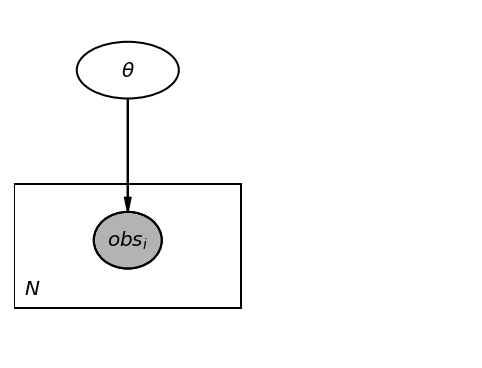

In [4]:
import daft

pgm = daft.PGM([4, 3], origin=[0, 0])
pgm.add_node(daft.Node("theta", r"$\theta$", 1, 2.5, aspect=1.8))

pgm.add_node(daft.Node("obs", r"$obs_i$", 1, 1, aspect=1.2, observed=True))

pgm.add_edge("theta", "obs")
pgm.add_plate([0, 0.5, 2, 1.0], label=r"$N$", shift=-0.1)
pgm.render()

#### Obtaining MLE analytically for different dataset sizes

In [5]:
dataset_large = distribution.sample(100000)

mle_estimate = {}
for dataset_size in [10, 50, 100, 500, 1000, 10000, 100000]:
    mle_estimate[dataset_size] = tf.reduce_mean(
        tf.cast(dataset_large[:dataset_size], tf.float32)
    )
tf.print(mle_estimate)

{10: 0.9,
 50: 0.76,
 100: 0.71,
 500: 0.746,
 1000: 0.749,
 10000: 0.749,
 100000: 0.75144}


As we can see above, when we use larger dataset sizes, our estimate matches the value we set (0.75).

#### Using TFP for MLE

In [6]:
##### Model setup

In [7]:
theta = tf.Variable(0.1)
fit = tfd.Bernoulli(probs=theta)

fit.log_prob(dataset_10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.10536052, -0.10536052, -0.10536052, -2.3025851 , -2.3025851 ,
       -2.3025851 , -2.3025851 , -2.3025851 , -0.10536052, -2.3025851 ],
      dtype=float32)>

##### Defining loss
We now define the negative log likelihood as our loss function and work towards minimizing it. 

In [8]:
dataset = dataset_10


def loss():
    return -tf.reduce_mean(fit.log_prob(dataset))

##### Tracing variables over training

In [9]:
trace_fn = lambda traceable_quantities: {
    "loss": traceable_quantities.loss,
    "theta": theta,
}

num_steps = 150

##### Minimizing the loss function

In [10]:
trace = tfp.math.minimize(
    loss_fn=loss,
    num_steps=num_steps,
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    trace_fn=trace_fn,
)

In [11]:
theta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5981373>

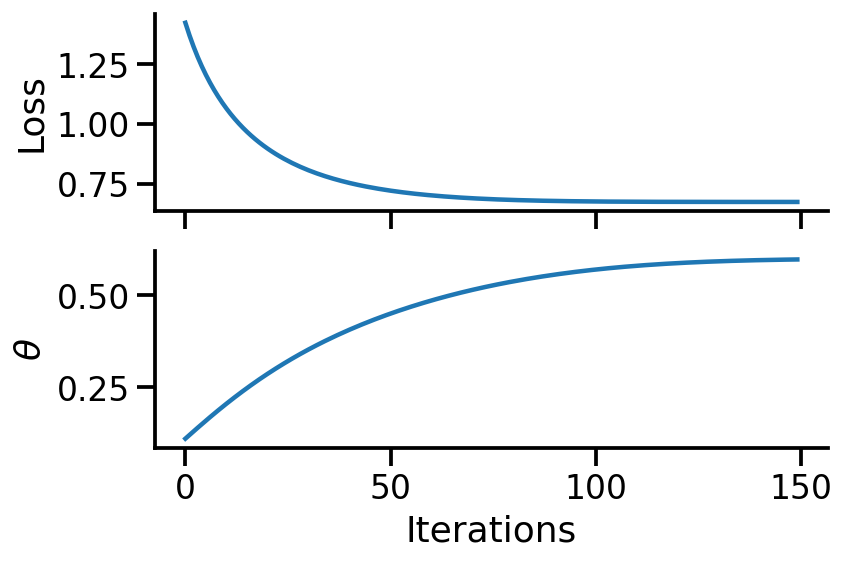

In [12]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 4))
ax[0].plot(range(num_steps), trace["loss"])
ax[1].plot(range(num_steps), trace["theta"])
sns.despine()
ax[1].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel(r"$\theta$")
fig.tight_layout()

From the above calculations, we can see that we have obtained the same estimate of ~0.6 using TFP.  

##### Alternate way to minimize

Previously, we used the tf.math.minimize, but we can also use tf.GradientTape() for the same purpose.

In [13]:
@tf.function
def loss_and_grads(fit):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(fit.log_prob(dataset))
    return loss, tape.gradient(loss, fit.trainable_variables)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


theta = tf.Variable(0.1)
fit = tfd.Bernoulli(probs=theta)


for i in range(num_steps):
    loss, grads = loss_and_grads(fit)
    optimizer.apply_gradients(zip(grads, fit.trainable_variables))

In [14]:
fit.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5981373>,)

We can see that we obtain the same estimate.

### MAP

We will now be setting a prior over $\theta$. A general graphical model is shown below. 

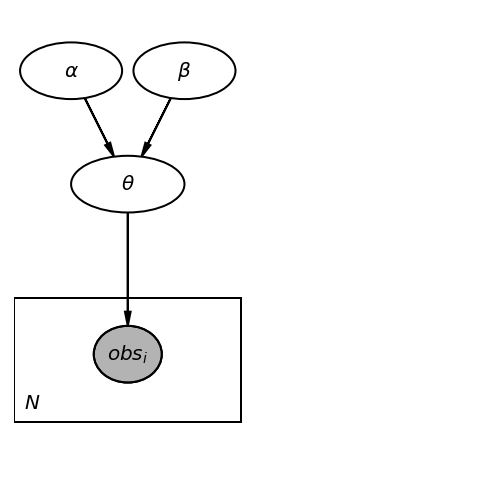

In [15]:
pgm = daft.PGM([4, 4], origin=[0, 0])
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 3.5, aspect=1.8))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 3.5, aspect=1.8))


pgm.add_node(daft.Node("theta", r"$\theta$", 1, 2.5, aspect=2))
# pgm.add_node(daft.Node("theta", r"$\theta\sim Beta (\alpha, \beta)$", 1, 2.5, aspect=4))

pgm.add_node(daft.Node("obs", r"$obs_i$", 1, 1, aspect=1.2, observed=True))

pgm.add_edge("theta", "obs")
pgm.add_edge("alpha", "theta")
pgm.add_edge("beta", "theta")


pgm.add_plate([0, 0.5, 2, 1.0], label=r"$N$", shift=-0.1)
pgm.render()

##### MAP with uniform prior

First, we see the estimate for $\theta$ if we use the uniform prior. We should obtain the MLE answer. 

In [16]:
def coin_toss_uniform_model():
    theta = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Uniform(low=0.0, high=1.0, name="Theta")
    )

    coin = yield tfp.distributions.Bernoulli(probs=tf.ones(100) * theta, name="Coin")

In [17]:
coin_toss_uniform_model

<function __main__.coin_toss_uniform_model()>

In [18]:
model_joint_uniform = tfp.distributions.JointDistributionCoroutineAutoBatched(
    lambda: coin_toss_uniform_model(), name="Original"
)

In [19]:
model_joint_uniform

<tfp.distributions.JointDistributionCoroutineAutoBatched 'Original' batch_shape=[] event_shape=StructTuple(
  Theta=[],
  Coin=[100]
) dtype=StructTuple(
  Theta=float32,
  Coin=int32
)>

In [20]:
def uniform_model(dataset):
    num_datapoints = len(dataset)
    theta = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Uniform(low=0.0, high=1.0, name="Theta")
    )
    coin = yield tfp.distributions.Bernoulli(
        probs=tf.ones(num_datapoints) * theta, name="Coin"
    )

In [21]:
concrete_uniform_model = functools.partial(uniform_model, dataset=dataset_10)

model = tfd.JointDistributionCoroutineAutoBatched(concrete_uniform_model)

In [22]:
model.sample()

StructTuple(
  Theta=<tf.Tensor: shape=(), dtype=float32, numpy=0.5930122>,
  Coin=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 0, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int32)>
)

In [23]:
th = tf.Variable(0.4)

target_log_prob_fn = lambda th: model.log_prob((th, dataset_10))
target_log_prob_fn

<function __main__.<lambda>(th)>

In [24]:
trace = tfp.math.minimize(
    lambda: -target_log_prob_fn(th),
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    # trace_fn=trace_fn,
    num_steps=200,
)

In [25]:
th

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.59999406>

In [26]:
mle_estimate_10

<tf.Tensor: shape=(), dtype=float32, numpy=0.6>

We see above that our MAP estimate is fairly close to the MLE when we used the uniform prior. 

##### MAP with Beta prior

We will now use a much more informative prior -- the Beta prior. We will be setting $\alpha=40$ and $\beta=10$ indicating that we have a prior belief that Tails is much more likely than Heads. This is a bad assumption and in the limited data regime will lead to poor estimates. 

In [27]:
def beta_prior_model(dataset):
    num_datapoints = len(dataset)
    theta = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Beta(concentration0=40, concentration1=10, name="Theta")
    )
    coin = yield tfp.distributions.Bernoulli(
        probs=tf.ones(num_datapoints) * theta, name="Coin"
    )

In [28]:
concrete_beta_prior_model = functools.partial(beta_prior_model, dataset=dataset_10)

In [29]:
model_2 = tfd.JointDistributionCoroutineAutoBatched(concrete_beta_prior_model)

In [30]:
model_2.sample()

StructTuple(
  Theta=<tf.Tensor: shape=(), dtype=float32, numpy=0.16982338>,
  Coin=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>
)

In [31]:
th = tf.Variable(0.2)

target_log_prob_fn = lambda th: model_2.log_prob((th, dataset_10))
target_log_prob_fn

<function __main__.<lambda>(th)>

In [32]:
trace = tfp.math.minimize(
    lambda: -target_log_prob_fn(th),
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    # trace_fn=trace_fn,
    num_steps=200,
)

In [33]:
th

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25861916>

We now see that our MAP estimate for $\theta$ is 0.25, which is very far from the MLE. Choosing a better prior would have led to better estimates. Or, if we had more data, the likelihood would have dominated over the prior resulting in better estimates. 

### Fully Bayesian


#### References (incomplete as of now)

1. https://www.youtube.com/watch?v=o42mnEvHmss